# Sprint 16, Task 1

## Level 1

### Exercise 1

Take whichever dataset you prefer and build a pipeline and GridSearch applying the Random Forest algorithm:

In [1]:
# First, import all important libraries:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

import sqlite3


In [2]:
# SQL query to get only important features

sql = """
SELECT finishing, heading_accuracy, volleys, free_kick_accuracy, shot_power, long_shots, penalties
FROM PLAYER_ATTRIBUTES
"""

con = sqlite3.connect("../Sprint 07/database.sqlite")

attributes = pd.read_sql_query(sql, con)

In [3]:
# Filter out and fill in NaN

attributes.dropna(how="all", inplace=True)

attributes["volleys"].fillna(value=attributes["volleys"].mean(), inplace= True)

<AxesSubplot:>

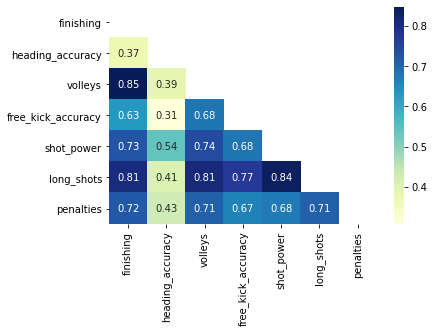

In [4]:
# Check which attributes have a higher correlation:

corr = attributes.corr()

# Numpy's triu gets the upper triangle of the array. Mask parameter then hides it
mask = np.triu(corr)

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask= mask, cmap="YlGnBu")

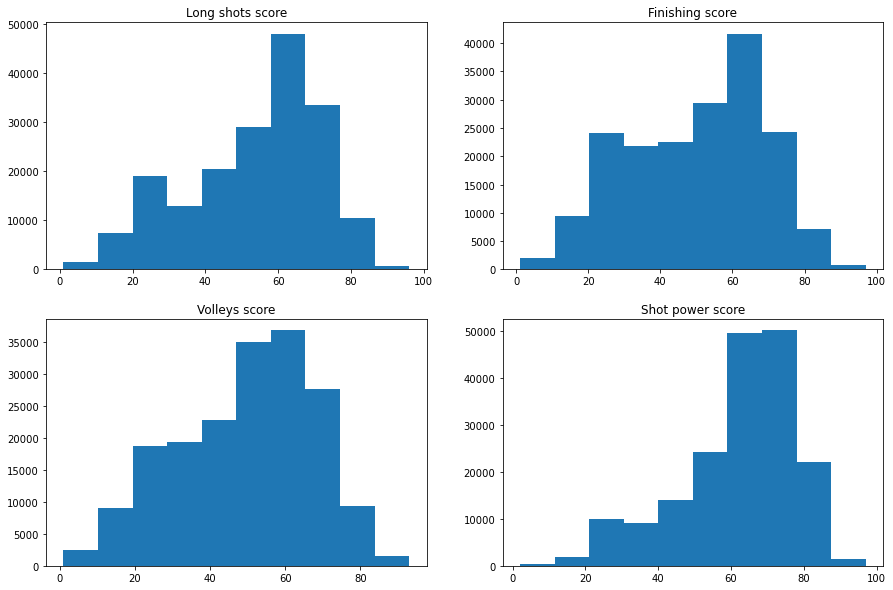

In [5]:
# See if data follows more or less a normal distribution:

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.title("Long shots score")
plt.hist(attributes["long_shots"])

plt.subplot(2, 2, 2)
plt.title("Finishing score")
plt.hist(attributes["finishing"])

plt.subplot(2, 2, 3)
plt.title("Volleys score")
plt.hist(attributes["volleys"])

plt.subplot(2, 2, 4)
plt.title("Shot power score")
plt.hist(attributes["shot_power"])

plt.show()

# Since the data is skewed (no Gauss distribution) we will normalise instead of standardise

In [6]:
# Split data into predictors, target; test and train sets:

y_pipe = attributes["long_shots"]
X_pipe = attributes[["finishing", "volleys", "shot_power"]]

X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(X_pipe, y_pipe, random_state = 12)



In [7]:
# Instantiate the Pipeline: 

# We normalise with MinMaxScaler since the independent variables are not normally distributed
# We use the Random Forest regression model

model_pipeline = Pipeline([
                                ("Preprocessing", MinMaxScaler()),
                                ('Random_forest', RandomForestRegressor(max_depth=10, random_state=2))
                                 ])

In [8]:

# Note: Pipeline only preprocesses the independent variables, so to get normalised results it would be necessary to
# process the dependent variables beforehand. One must be careful, however, with standardising dependent variables
# at the same time, since it can end up leaking/losing information. If you have to standardise, fit X_train and 
# transform X_test, y_train and y_test with it

# Pipelines are easy to scale up, so in case that a new step wants to be added (like imputing NaNs, or trying
# several regression models) it is very easy and exportable

# Useful pipeline-related functions:
    # ColumnTransformer: to apply different functions to different columns
    # SimpleImputer: to impute more easily
    # FuntionTransformer: since Pipeline only accepts functions that can be called with fit(/transform), this
        # transforms any given function into a Pipeline-able function
    # DataFrameMapper: applies a Sklearn preprocessing function to a given column
        

In [9]:
# Fit the model

model_pipeline.fit(X_train_pipe, y_train_pipe)

Pipeline(steps=[('Preprocessing', MinMaxScaler()),
                ('Random_forest',
                 RandomForestRegressor(max_depth=10, random_state=2))])

In [10]:
# Predict Y values with X_test

Y_pred_pipe = model_pipeline.predict(X_test_pipe)

In [11]:
# Feature importances:

print(model_pipeline[1][1].feature_importances_)
# 66% of the long shots is explained by finishing, and 29% by shot power, according to this model

# R^2 score:

print(r2(Y_pred_pipe, y_test_pipe))
# More or less OK indicator (reminder: the closest to 1, the better)

# RMSE:

print(np.sqrt(mse(Y_pred_pipe, y_test_pipe)))
# SEE VARIANCE

[0.66395533 0.05048508 0.28555959]
0.8140982515951911
7.242965514409836


In [12]:
# New train/test split:

X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X_pipe, y_pipe, random_state = 88)

In [13]:
# Definition of the GridSearch parameters:

parameters = {'Random_forest__n_estimators': [200, 300],
              'Random_forest__max_depth': [10, 20], 
              "Random_forest__min_samples_leaf": [1, 2]}

grid = GridSearchCV(model_pipeline, parameters, cv=2)

grid.fit(X_train_grid, y_train_grid)

# Run time: aprox 7 min

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Preprocessing', MinMaxScaler()),
                                       ('Random_forest',
                                        RandomForestRegressor(max_depth=10,
                                                              random_state=2))]),
             param_grid={'Random_forest__max_depth': [10, 20],
                         'Random_forest__min_samples_leaf': [1, 2],
                         'Random_forest__n_estimators': [200, 300]})

In [14]:
# Print parameters that gave the best score:

best_params = grid.best_params_
print(best_params)

# As can be seen, the larger the number of estimators, the better the result. However, this also implies more
# computational time, so a tradeoff has to be found

# We save the best hyperparameters into a new pipeline:

best_pipe = grid.best_estimator_
print(best_pipe)


{'Random_forest__max_depth': 20, 'Random_forest__min_samples_leaf': 1, 'Random_forest__n_estimators': 300}
Pipeline(steps=[('Preprocessing', MinMaxScaler()),
                ('Random_forest',
                 RandomForestRegressor(max_depth=20, n_estimators=300,
                                       random_state=2))])


In [15]:
# Predict Y values:

Y_pred_grid = grid.predict(X_test_grid)

In [16]:
# Feature importances:

print(best_pipe[1][1].feature_importances_)

# The modified pipeline gives importance to all three predictor variables

# R^2 score:

print(r2(Y_pred_grid, y_test_grid))

# Much better score than before using GridSearch

# RMSE:

print(np.sqrt(mse(Y_pred_grid, y_test_grid)))

# More than 2 points reduction than before GridSearch


[0.61939638 0.10103412 0.27956949]
0.9149062906353783
5.158614260069895


In [ ]:
# Overall, significant prediction improvement after using GridSearch